In [1]:
# |default_exp learner

In [109]:
# |export
import math
from copy import copy
from operator import attrgetter
from collections.abc import Mapping
from functools import partial

import torch
from torch import optim

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR

from torcheval.metrics import Mean

import fastcore.all as fc
from fastprogress import progress_bar, master_bar

import matplotlib.pyplot as plt

import miniai.datasets as ds
import miniai.conv as cv

In [108]:
from torch import nn, tensor
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torcheval.metrics import MulticlassAccuracy

# Learner

## Data

Not part of the learner, just used for testing in the nb.

In [4]:
from datasets import load_dataset

x_name = "image"
y_name = "label"
dataset_name = "fashion_mnist"

dataset_dict = load_dataset(dataset_name)

In [5]:
@ds.inplace
def transformi(items):
    items[x_name] = [torch.flatten(TF.to_tensor(img)) for img in items[x_name]]

In [6]:
tdataset_dict = dataset_dict.with_transform(transformi)
batch_size = 1024

## DataLoaders

In [7]:
# |export


class DataLoaders:
    """Holds training and validation dataloaders."""

    def __init__(self, *dls):
        """Accepts a train and valid dataloader."""
        self.train, self.valid = dls[:2]

    @classmethod
    def from_dsd(cls, dsd, batch_size, num_workers=4):
        """Create dataloaders from a dataset dict."""
        return cls(
            *[DataLoader(d, batch_size, num_workers=num_workers, collate_fn=ds.collate_dict(d)) for d in dsd.values()]
        )

In [8]:
dls = DataLoaders.from_dsd(tdataset_dict, batch_size)
train_ds = dls.train

xb, yb = next(iter(train_ds))
xb.shape, yb[:5], yb.shape

(torch.Size([1024, 784]), tensor([9, 0, 0, 3, 0]), torch.Size([1024]))

## Learner v1

In [9]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        fc.store_attr()

    def _calc_stats(self):
        """Calc the accuracy and loss stats for the current batch and add the the lists."""
        acc = (self.preds.argmax(dim=1) == self.yb).float().sum()
        self.accs.append(acc)

        self.losses.append(self.loss * len(self.xb))
        self.ns.append(len(self.xb))

    def _one_batch(self):
        """Run one training/validation for one batch of data."""
        self.xb, self.yb = cv.to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)

        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

        with torch.no_grad():
            self._calc_stats()

    def _one_epoch(self, train):
        """Run a single epoch of training or validation."""
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid

        for self.num, self.batch in enumerate(dl):
            self._one_batch()

        N = sum(self.ns)
        print(
            "epoch: ",
            self.epoch,
            "train:",
            self.model.training,
            "loss: ",
            sum(self.losses).item() / N,
            "accuracy: ",
            sum(self.accs).item() / N,
        )

    def fit(self, n_epochs):
        """Run training and validation for a number of epochs."""
        self.accs = []
        self.losses = []
        self.ns = []

        self.model.to(cv.def_device)

        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs

        for self.epoch in range(n_epochs):
            self._one_epoch(True)
            self._one_epoch(False)

In [10]:
# Now we have a learner that can fit things
# It works, but its not very flexible

n_pixels = 28 * 28
n_hidden = 50

model = nn.Sequential(nn.Linear(n_pixels, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))
learn = Learner(model, dls, F.cross_entropy, lr=0.2)

learn.fit(5)

epoch:  0 train: True loss:  1.1804802083333332 accuracy:  0.6001
epoch:  0 train: False loss:  1.1262668526785715 accuracy:  0.6135285714285714
epoch:  1 train: True loss:  0.9368109375 accuracy:  0.6734153846153846
epoch:  1 train: False loss:  0.9230771205357143 accuracy:  0.6769285714285714
epoch:  2 train: True loss:  0.83165921875 accuracy:  0.7087
epoch:  2 train: False loss:  0.8199018601190476 accuracy:  0.7125666666666667
epoch:  3 train: True loss:  0.7640081597222222 accuracy:  0.7322740740740741
epoch:  3 train: False loss:  0.7567142299107142 accuracy:  0.7346678571428571
epoch:  4 train: True loss:  0.7173293658088236 accuracy:  0.7484647058823529
epoch:  4 train: False loss:  0.7120141071428572 accuracy:  0.75026


## Basic callbacks

Our current learner is on rails. It does what it does. Lets add a callback system so that we can hook into each stage of the learning process and do extra things. We'll use this for mertrics and additional reporting in the future.

In [11]:
# |export


# Base class for all callbacks
class Callback:
    order = 0


# Exceptions thrown by Callbacks exception occurs in the related function
class CancelFitException(Exception):
    pass


class CancelBatchException(Exception):
    pass


class CancelEpochException(Exception):
    pass


# Runs the given method on all callbacks in order
def run_cbs(cbs, method_name):
    for cb in sorted(cbs, key=attrgetter("order")):
        method = getattr(cb, method_name, None)
        if method is not None:
            method()

In [12]:
# Here is an example of a callback
class BatchCounter(Callback):
    def before_fit(self):
        self.count = 0

    def after_batch(self):
        self.count += 1

    def after_fit(self):
        print(f"Counted {self.count} batches.")


cbs = [BatchCounter()]
run_cbs(cbs, "before_fit")
run_cbs(cbs, "after_batch")
run_cbs(cbs, "after_batch")
run_cbs(cbs, "dont_exist")
run_cbs(cbs, "after_fit")

Counted 2 batches.


In [13]:
# We can update our learner to run these callbacks after each stage
class Learner:
    def __init__(self, model, dls, loss_func, lr, callbacks, opt_func=optim.SGD):
        fc.store_attr()
        for cb in self.callbacks:
            cb.learn = self

    def one_batch(self):
        """Run one training/validation for one batch of data."""
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])

        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        """Run a single epoch of training or validation."""
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid

        try:
            self.callback("before_epoch")

            for self.num, self.batch in enumerate(self.dl):
                try:
                    self.callback("before_batch")
                    self.one_batch()
                    self.callback("after_batch")
                except CancelBatchException:
                    pass

            self.callback("after_epoch")
        except CancelEpochException:
            pass

    def fit(self, n_epochs):
        """Run training and validation for a number of epochs."""
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)

        try:
            self.callback("before_fit")

            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)

            self.callback("after_fit")
        except CancelFitException:
            pass

    def callback(self, method_name):
        """ "Go through callbacks, sorted by the order attribute and call their relavant method name."""
        run_cbs(self.callbacks, method_name)

In [14]:
# It seems to be working but we've lost all of our metrics
model = nn.Sequential(nn.Linear(n_pixels, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))
learn = Learner(model, dls, F.cross_entropy, lr=0.2, callbacks=[BatchCounter()])

learn.fit(1)

Counted 69 batches.



## CUDA

Lets implement a callback that helps us move data to our device to help speed things up.

In [15]:
# |export


class DeviceCB(Callback):
    def __init__(self, device=cv.def_device):
        fc.store_attr()

    """Moves the model to the device before fitting and the batch before each batch."""

    def before_fit(self):
        self.learn.model.to(self.device)

    def before_batch(self):
        self.learn.batch = cv.to_device(self.learn.batch, device=self.device)

In [16]:
# It still seems to work
model = nn.Sequential(nn.Linear(n_pixels, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))
learn = Learner(model, dls, F.cross_entropy, lr=0.2, callbacks=[BatchCounter(), DeviceCB()])

learn.fit(1)

Counted 69 batches.


## Metrics

We're coing to need to put metrics back in. In the pase we could only use accuracy as a metric. We want to be able to use other things.

In [17]:
class Metric:
    def __init__(self):
        self.reset()

    def reset(self):
        """Forget all previous values"""
        self.vals = []
        self.batch_sizes = []

    def add(self, inputs, targets=None, batch_size=1):
        """Add additional data for this metric"""
        self.last = self.calc(inputs, targets)
        self.vals.append(self.last)
        self.batch_sizes.append(batch_size)

    @property
    def value(self):
        """Calculates the overall current value for this metric across all batches."""
        tns = tensor(self.batch_sizes)
        return (tensor(self.vals) * tns).sum() / tns.sum()

    def calc(self, inputs, targets):
        """The calculation for one batch of inputs/targets for this metric"""
        return inputs

In [18]:
# Now we have a base metric class that can handle scalars and tensors depending on the calc function
loss = Metric()
loss.add(0.5, batch_size=10)  # Add 10 0.5's
print(loss.value)

loss.add(0, batch_size=5)  #  Add 5 0's
print(loss.value)

loss.add(0, batch_size=5)  #  Add 5 more 0's
print(loss.value)

tensor(0.5000)
tensor(0.3333)
tensor(0.2500)


In [19]:
class Accuracy(Metric):
    """
    An accuracy metric, ie a pass/fail
    comparison of the prediction inputs agains the targets.
    """

    def calc(self, inputs, targets):
        return (inputs == targets).float().mean()

In [20]:
# We can easily make new metrics like Accuracy
acc = Accuracy()

# Add fully accurate
acc.add(tensor([1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1]))
print(acc.value)

# Add fully inaccurate
acc.add(tensor([1, 1, 1, 1, 1]), tensor([0, 0, 0, 0, 0]))
print(acc.value)

# Add a mix
acc.add(tensor([1, 1, 1, 0, 0]), tensor([0, 0, 0, 0, 0]))
print(acc.value)

tensor(1.)
tensor(0.5000)
tensor(0.4667)


The good news is what we've invented already exists in `torcheval.metrics`. We'll just use this rather than reimplementing a bunch of metrics ourselves. It works in pretty much the same way.

In [21]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 0, 0, 0]), tensor([1, 1, 0, 0]))
metric.compute()

tensor(0.5000)

### Metrics callbacks

Lets create a callback to calculate some metrics for us.

In [106]:
# |export


def to_cpu(x):
    """Takes maps, lists and tuples of tensors or just tensors and moves them to the cpu"""
    if isinstance(x, Mapping):
        return {k: to_cpu(v) for k, v in x.items()}
    if isinstance(x, list):
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple):
        return tuple(to_cpu(list(x)))

    res = x.detach().cpu()
    return res.float() if res.dtype == torch.float16 else res


class MetricsCB(Callback):
    """Tracks a set of metrics + a loss (weighted avg of the losses)."""

    def __init__(self, *pos_metrics, **metrics):
        # Positional args become metrics named after the type of the class
        for metric in pos_metrics:
            metrics[type(metric).__name__] = metric

        self.metrics = metrics
        self.loss = Mean()

        self.all_metrics = copy(metrics)
        self.all_metrics["loss"] = self.loss

    def _log(self, data):
        print(data)

    def before_fit(self):
        self.learn.metrics = self

    def before_epoch(self):
        for metric in self.all_metrics.values():
            metric.reset()

    def after_epoch(self):
        data = {"epoch": self.learn.epoch, "train": "train" if self.learn.model.training else "eval"}

        for name, metric in self.all_metrics.items():
            data[name] = f"{metric.compute():.3f}"

        self._log(data)

    def after_batch(self):
        # We need to make sure all tensors are on the same device so just move them to the CPU
        x, y = to_cpu(self.learn.batch)
        preds = to_cpu(self.learn.preds)
        loss = to_cpu(self.learn.loss)

        # Update all of the metrics
        for metric in self.metrics.values():
            metric.update(preds, y)

        # Update our loss
        self.loss.update(loss, weight=len(x))

In [23]:
# Lets give it a whirl, hurray we've got our metrics back
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics]
model = nn.Sequential(nn.Linear(n_pixels, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))
learn = Learner(model, dls, F.cross_entropy, lr=0.2, callbacks=cbs)

learn.fit(5)

{'epoch': 0, 'train': 'train', 'accuracy': '0.601', 'loss': '1.183'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.693', 'loss': '0.822'}
{'epoch': 1, 'train': 'train', 'accuracy': '0.742', 'loss': '0.718'}
{'epoch': 1, 'train': 'eval', 'accuracy': '0.755', 'loss': '0.657'}
{'epoch': 2, 'train': 'train', 'accuracy': '0.783', 'loss': '0.616'}
{'epoch': 2, 'train': 'eval', 'accuracy': '0.793', 'loss': '0.581'}
{'epoch': 3, 'train': 'train', 'accuracy': '0.800', 'loss': '0.569'}
{'epoch': 3, 'train': 'eval', 'accuracy': '0.813', 'loss': '0.541'}
{'epoch': 4, 'train': 'train', 'accuracy': '0.814', 'loss': '0.532'}
{'epoch': 4, 'train': 'eval', 'accuracy': '0.805', 'loss': '0.538'}


## Learner v2

We can tidy up our learner by using a decorator to augment functions in our learner with callbacks. This means we can easily add more callbacks that we'll use soon. We'll make it so you can do the actual training in a callback by adding `predict`, `calc_loss`, `backward`, `step` and `zero_trad` calls.

In [96]:
# |export


class with_cbs:
    """
    Decorator that adds before and after callbacks to a function.
    If an exception is thrown then a cleanup_* callback is called.
    """

    def __init__(self, name):
        self.name = name

    def __call__(self, fn):
        def _fn(o, *args, **kwargs):
            try:
                o.callback(f"before_{self.name}")
                fn(o, *args, **kwargs)
                o.callback(f"after_{self.name}")
            except globals()[f"Cancel{self.name.title()}Exception"]:
                pass
            finally:
                o.callback(f"cleanup_{self.name}")

        return _fn

In [25]:
# |export


class Learner:
    def __init__(self, model, dls, loss_func, lr, callbacks, opt_func=optim.SGD):
        fc.store_attr()
        for cb in self.callbacks:
            cb.learn = self

    @with_cbs("batch")
    def one_batch(self):
        """Run one training/validation for one batch of data."""
        self.predict()
        self.calc_loss()

        if self.model.training:
            self.backward()
            self.step()
            self.zero_grad()

    def one_epoch(self, train):
        """Run a single epoch of training or validation."""
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid

        self._one_epoch()

    @with_cbs("epoch")
    def _one_epoch(self):
        for self.num, self.batch in enumerate(self.dl):
            self.one_batch()

    def fit(self, n_epochs):
        """Run training and validation for a number of epochs."""
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)

        self._fit()

    @with_cbs("fit")
    def _fit(self):
        for self.epoch in self.epochs:
            self.one_epoch(True)
            self.one_epoch(False)

    def __getattr__(self, name):
        # If these methods dont exist, we are going to defer them to our callbacks
        # so we return a partial that calls our callback fn.
        if name in ("predict", "calc_loss", "backward", "step", "zero_grad"):
            return partial(self.callback, name)

        raise AttributeError(name)

    def callback(self, method_name):
        """ "Go through callbacks, sorted by the order attribute and call their relavant method name."""
        run_cbs(self.callbacks, method_name)


# This means we'll need a TrainCB to make things work
class TrainCB(Callback):
    def predict(self):
        self.learn.preds = self.learn.model(self.learn.batch[0])

    def calc_loss(self):
        self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])

    def backward(self):
        self.learn.loss.backward()

    def step(self):
        self.learn.opt.step()

    def zero_grad(self):
        self.learn.opt.zero_grad()

In [26]:
# Everything still works, but now we could use a different learning step if we want
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, TrainCB()]
model = nn.Sequential(nn.Linear(n_pixels, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))
learn = Learner(model, dls, F.cross_entropy, lr=0.2, callbacks=cbs)

learn.fit(1)

{'epoch': 0, 'train': 'train', 'accuracy': '0.606', 'loss': '1.188'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.695', 'loss': '0.804'}


## Progress bar

We can implement a progress bar as a callback.

In [27]:
# |export


class ProgressCB(Callback):
    order = MetricsCB.order + 1

    def __init__(self, plot=False):
        fc.store_attr()

    def before_fit(self):
        # Change the epochs to a progress bar around a range
        self.bar = master_bar(self.learn.epochs)
        self.learn.epochs = self.bar
        self.losses = []

    def before_epoch(self):
        # Wrap the dataloaders in a progress bar
        self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.bar)

    def after_batch(self):
        # Set the progresss bars comment to be the current loss
        self.learn.dl.comment = f"{self.learn.loss:.3f}"

        # Update the plot if requested
        if self.plot and self.learn.model.training:
            self.losses.append(self.learn.loss.item())
            self.bar.update_graph([[fc.L.range(self.losses), self.losses]])

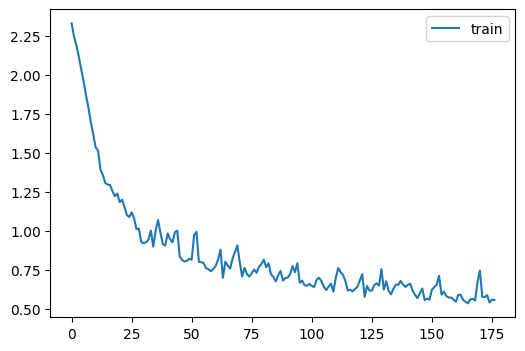

{'epoch': 0, 'train': 'train', 'accuracy': '0.606', 'loss': '1.192'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.713', 'loss': '0.778'}
{'epoch': 1, 'train': 'train', 'accuracy': '0.741', 'loss': '0.725'}
{'epoch': 1, 'train': 'eval', 'accuracy': '0.752', 'loss': '0.666'}
{'epoch': 2, 'train': 'train', 'accuracy': '0.783', 'loss': '0.617'}
{'epoch': 2, 'train': 'eval', 'accuracy': '0.775', 'loss': '0.642'}


In [28]:
# Now we get a progress bar too
metrics = MetricsCB(accuracy=MulticlassAccuracy())

cbs = [DeviceCB(), metrics, TrainCB(), ProgressCB(plot=True)]
model = nn.Sequential(nn.Linear(n_pixels, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))
learn = Learner(model, dls, F.cross_entropy, lr=0.2, callbacks=cbs)

learn.fit(3)

### Momentum learner

We dont have to implement the `predict/calc_loss/backward/step/zero_grad` methods in a callback. As its aonly called in a callback if  it doesnt exist on the learner we can also just subclass `Learner`.

In [30]:
# |export


class MomentumLearner(Learner):
    """
    Our MomentumLearner behaves a bit differently.
    Instead of zeroing the gradient in zero_grad it multiplies them by a number (generally < 1).
    This means that the previous gradients still exist but in a reduced form,
    giving the learner "momentum".
    """

    def __init__(self, model, dls, loss_func, lr, callbacks, opt_func=optim.SGD, momentum=0.85):
        self.momentum = momentum
        super().__init__(model, dls, loss_func, lr, callbacks, opt_func)

    def predict(self):
        self.preds = self.model(self.batch[0])

    def calc_loss(self):
        self.loss = self.loss_func(self.preds, self.batch[1])

    def backward(self):
        self.loss.backward()

    def step(self):
        self.opt.step()

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters():
                p.grad *= self.momentum

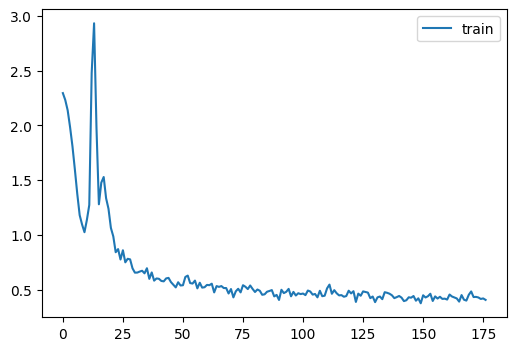

{'epoch': 0, 'train': 'train', 'accuracy': '0.677', 'loss': '1.004'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.800', 'loss': '0.567'}
{'epoch': 1, 'train': 'train', 'accuracy': '0.830', 'loss': '0.485'}
{'epoch': 1, 'train': 'eval', 'accuracy': '0.830', 'loss': '0.493'}
{'epoch': 2, 'train': 'train', 'accuracy': '0.847', 'loss': '0.435'}
{'epoch': 2, 'train': 'eval', 'accuracy': '0.836', 'loss': '0.474'}


In [37]:
# Lets give it a go
metrics = MetricsCB(accuracy=MulticlassAccuracy())

cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
model = nn.Sequential(nn.Linear(n_pixels, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, callbacks=cbs)

learn.fit(3)

Its improved! Normally this is done by storing a copy of the gradients and calculating a moving average.

### LR finder

Lets implement a learning rate finder. We'll increase the learining rate gradually over time, plot the loss agains the learning rate, we want to be able to pick a LR as high as possible without the loss getting worse.

In [70]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3):
        fc.store_attr()

    def before_fit(self):
        # We are going to track learning rates and losses
        self.lrs = []
        self.losses = []

        # And the min loss
        self.min = math.inf

    def after_batch(self):
        # If we are not training then stop
        if not self.learn.model.training:
            raise CancelEpochException()

        self.lrs.append(self.learn.opt.param_groups[0]["lr"])
        loss = to_cpu(self.learn.loss)
        self.losses.append(loss)

        if loss < self.min:
            self.min = loss

        # Stop training if the loss is 3x our min loss
        if loss > self.min * 3:
            raise CancelFitException()

        # Increase the lr by our multiplier
        for group in self.learn.opt.param_groups:
            group["lr"] *= self.lr_mult

    def plot(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale("log")

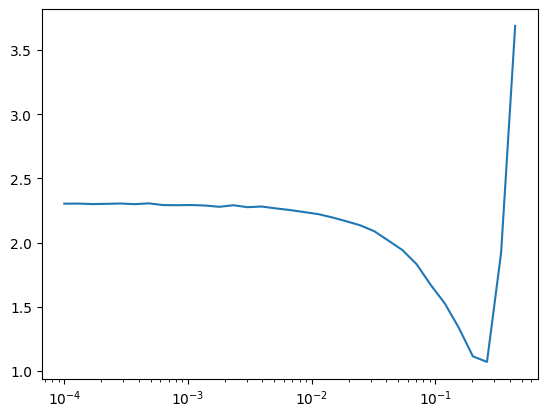

In [71]:
lr_find = LRFinderCB()
cbs = [DeviceCB(), lr_find]
model = nn.Sequential(nn.Linear(n_pixels, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=1e-4, callbacks=cbs)

learn.fit(1)
lr_find.plot()

pytorch gives use the ExponentialLR lr scheduler that lets does pretty much the same thing only a bit fancier. We can use it to implement a better LRFinderCB.

In [97]:
# |export


class LRFinderCB(Callback):
    def __init__(self, gamma=1.3):
        fc.store_attr()

    def before_fit(self):
        # Create a new LR scheduler
        self.sched = ExponentialLR(self.learn.opt, self.gamma)

        # We are going to track learning rates and losses
        self.lrs = []
        self.losses = []

        # And the min loss
        self.min = math.inf

    def after_batch(self):
        # If we are not training then stop
        if not self.learn.model.training:
            raise CancelEpochException()

        self.lrs.append(self.learn.opt.param_groups[0]["lr"])
        loss = to_cpu(self.learn.loss)
        self.losses.append(loss)

        if loss < self.min:
            self.min = loss

        # Stop training if the loss is 3x our min loss
        if loss > self.min * 3:
            raise CancelFitException()

        # Run 1 step of the scheduler
        self.sched.step()

    def cleanup_fit(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale("log")

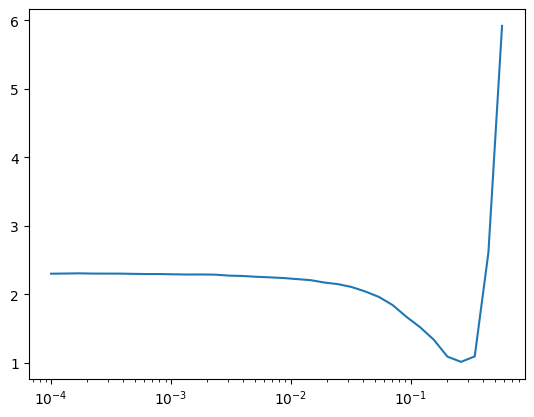

In [98]:
lr_find = LRFinderCB()
cbs = [DeviceCB(), lr_find]
model = nn.Sequential(nn.Linear(n_pixels, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=1e-4, callbacks=cbs)

learn.fit(1)